In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import json

from tqdm.notebook import tqdm

#sns.set_theme()

In [2]:
from datetime import datetime
import os

to_export = f'./Results/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}'
os.makedirs(to_export)

In [3]:
###################
### Parameters ###
###################

###############
## FOR MODEL ##
###############

data = {
'interest_rate' : 0.035,
'agents' : 10,
'periods' : 20
}

################
## FOR AGENTS ##
################
data.update({
       
# Wealth distribution parameter: The higher, the lower the inequality
"inequality_wealth" : 5, 

# Skills distribution parameter: The higher, the lower the inequality
"inequality_skills" : 3,
"weight_gen_skills" : 0.5, # theta in the paper (Meritocracy)

# Qualities and varieties parameters
"qualities" : 20, # Q in the paper
"varieties" : 10, # J in the paper

# Own good pricing parameters
"a" : 0.2, # a in the paper, that says it should be strictly larger than 0.
"alpha" : 1.5, # alpha in the paper, that says it should be strictly larger than 1

# Connectivity limits, parameters
"min_connectivity" : 2, # This is the N^0 of the paper
"max_connectivity" : data['agents'] - 1, # This is the \tilde{N} of the paper.

# Propensity to consume parameters
"pc_a" : 0.5, # a in the paper this a must be larger than 0.
"pc_c_l" : 0.1, # paper's c_l must be greater than 0 and lower than c_h
"pc_c_h" : 0.9, # paper's c_h must be larger than c_h but lower than 1.

# Connectivity update parameters
"connect_w" : 0.5, # w in the paper, must be >0, this reflects the importance of the change in wealth
"connect_b" : 0.5, # w in the paper, must be >0, this reflects the importance of the moral behavior

# Animal spirits parameters
"as_gamma" : 0.5, # gamma constant in the paper that states it should be in (0,1). Represents the importance of mean reversion.
"as_g" : 0.5, # g constant in the paper that states it should be in (0,1). Represents the importance of my friends.

# Moral behavior parameters
"mb_z" : 0.5, # constant z in the paper, reflects the influence of the peers, must be in (0,1)
"mb_zeta" : 0.5, # constant greek zeta in the paper, must be in (0,1) and weight of mean reversion.

# Political view parameters
"pv_x" : 0.5, # constant x in the paper must be in (0,1) and reflects influence of peers
"pv_omega" : 0.5 # constant omega in the paper must be in (0,1) reflects mean reversion
})

with open(f"{to_export}/latest_parameters.json", "w") as outfile: 
    json.dump(data, outfile)

In [4]:
from model import model

mymodel = model(data)

for _ in tqdm(range(data['periods'])):
    mymodel.step()

#############################
#   Get and store the data  #
#############################

results_model = mymodel.datacollector.get_model_vars_dataframe()
results_model.to_csv(f'{to_export}/results_model.csv')

results_agents = mymodel.datacollector.get_agent_vars_dataframe()
results_agents.to_csv(f'{to_export}/results_agents.csv')

g:\My Drive\Work\Research\Economics\Ongoing\ABM Wealth\ABM-Project-ISCAL\virtenv\Lib\site-packages\mesa\time.py:82: FutureWarning: The AgentSet is experimental. It may be changed or removed in any and all future releases, including patch releases.
We would love to hear what you think about this new feature. If you have any thoughts, share them with us here: https://github.com/projectmesa/mesa/discussions/1919
  self._agents: AgentSet = AgentSet(agents, model)


  0%|          | 0/20 [00:00<?, ?it/s]

In [5]:
df_model = results_model
df_agents = results_agents

In [6]:
number_of_agents = df_agents.loc[(1, slice(None)), :].shape[0]
number_of_periods = df_agents.loc[(slice(None), 1), :].shape[0]
print(f'We have a total of {number_of_agents} agents in the simulation, that ran for {number_of_periods-1} periods.')

n_rand_agents = 3
random_agents = random.sample(range(0, number_of_agents), n_rand_agents)

sample_agents = []

for i in random_agents:
    sample_agents.append(df_agents.loc[(slice(None) , i) , :].reset_index(level = 1, drop = True))

We have a total of 10 agents in the simulation, that ran for 20 periods.


## Some random agents

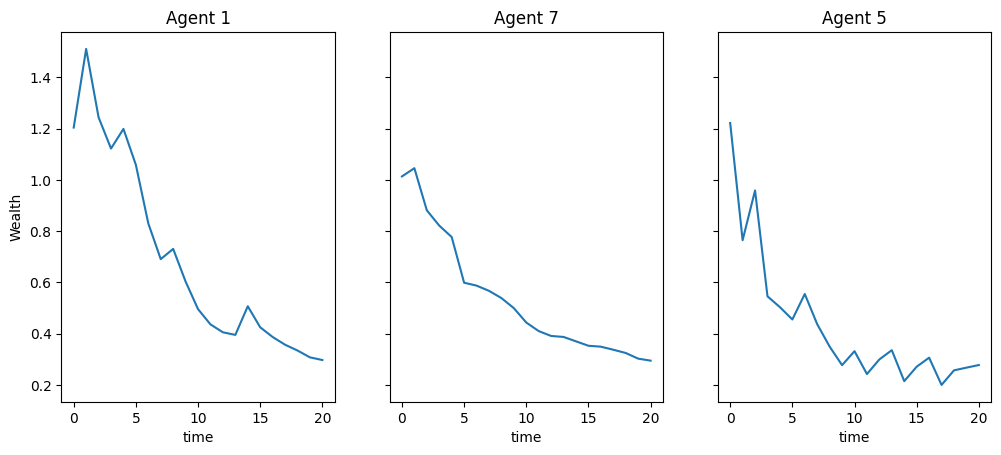

FileNotFoundError: [Errno 2] No such file or directory: '/Plots/sample_wealth.png'

<Figure size 640x480 with 0 Axes>

In [7]:
vars_to_plot = ['wealth', 'moral_behavior', 'connectivity', 'animal_spirits', 'consumption']

for v in vars_to_plot:

    fig, ax = plt.subplots(nrows=1, ncols=len(random_agents), sharey = True);
    fig.set(figwidth = 12)

    ax[0].set_ylabel(str.title(v));

    for i in range(n_rand_agents):
        ax[i].plot(sample_agents[i][v]);
        ax[i].set_xlabel('time');
        ax[i].set_title(f'Agent {random_agents[i]}');
    
    plt.show()
    plt.savefig(f'{to_export}/sample_{v}.png')

## Distributions

In [ ]:
def create_partitions(arr, n):
  size = len(arr)

  if n >= size:
    return list(range(size))
  elif size == 1:
    return [0]
  else:
    return [int(np.floor(i*(size-1)/(n-1))) for i in range(n)]

def make_hist(col):
  global steps
  subsample_cross = create_partitions(range(df_model.shape[0]), 3)

  plt.figure(figsize=(15, 15 ))
  plt.subplots_adjust(hspace=0.2)
  plt.suptitle(f"{str.title(col.replace('_',' '))}", fontsize=16, y=0.95)

  ncols = 3
  nrows = 3

  axes = []

  for n, ticker in enumerate(subsample_cross):
      if n == 0:
        axes.append(plt.subplot(nrows, ncols, n + 1))
      else:
        axes.append(plt.subplot(nrows, ncols, n + 1, sharey = axes[0]))
      axes[n].set_title(f't = {subsample_cross[n]}')
        
      df_agents.loc[(ticker, slice(None)), col].hist(ax = axes[n], bins = 20, weights = np.zeros_like(df_agents.loc[(ticker, slice(None)), col]) + 1./df_agents.loc[(ticker, slice(None)), col].size)

  plt.savefig(f'{to_export}/hist_{col}.png')

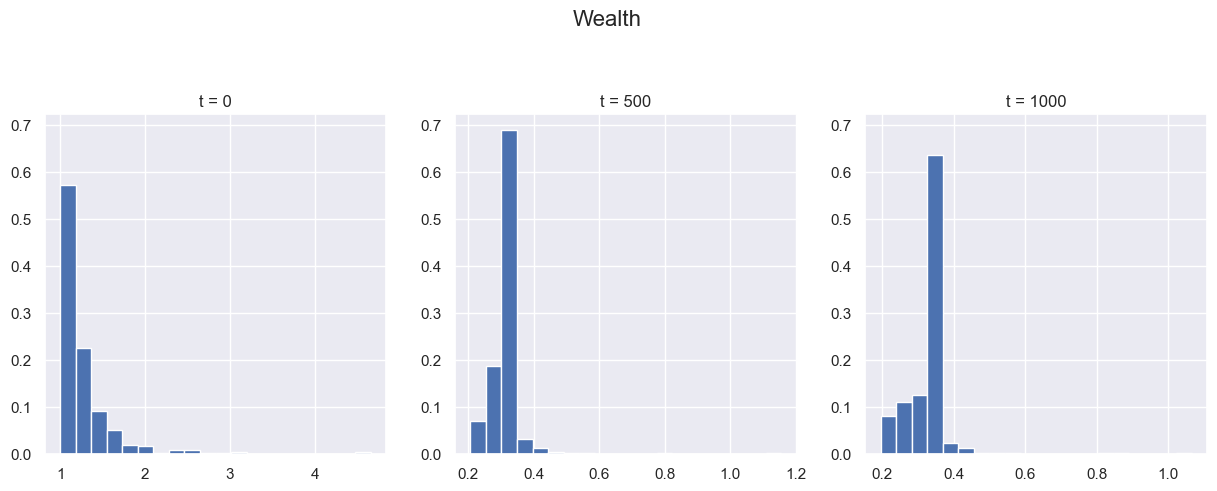

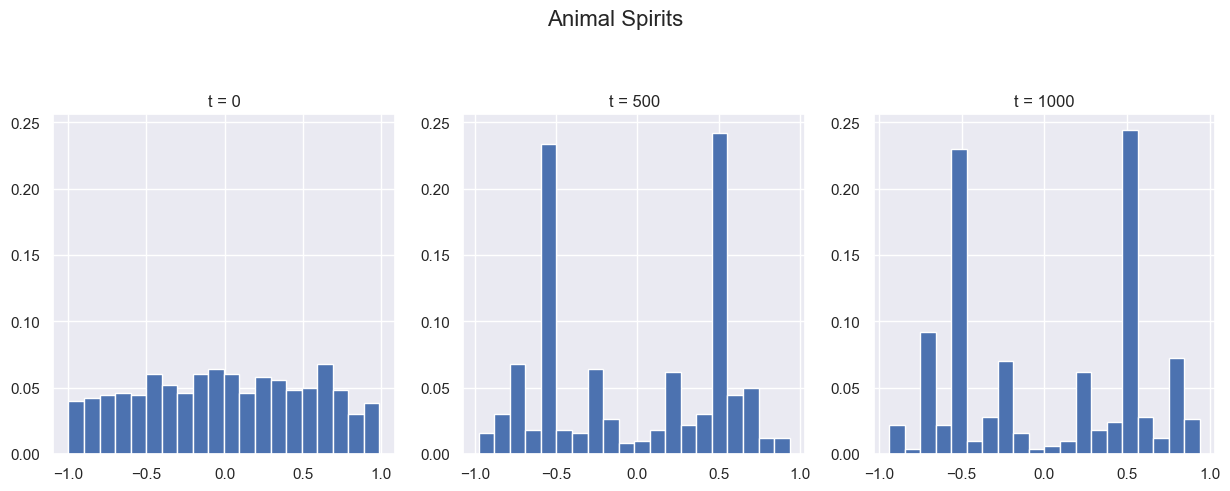

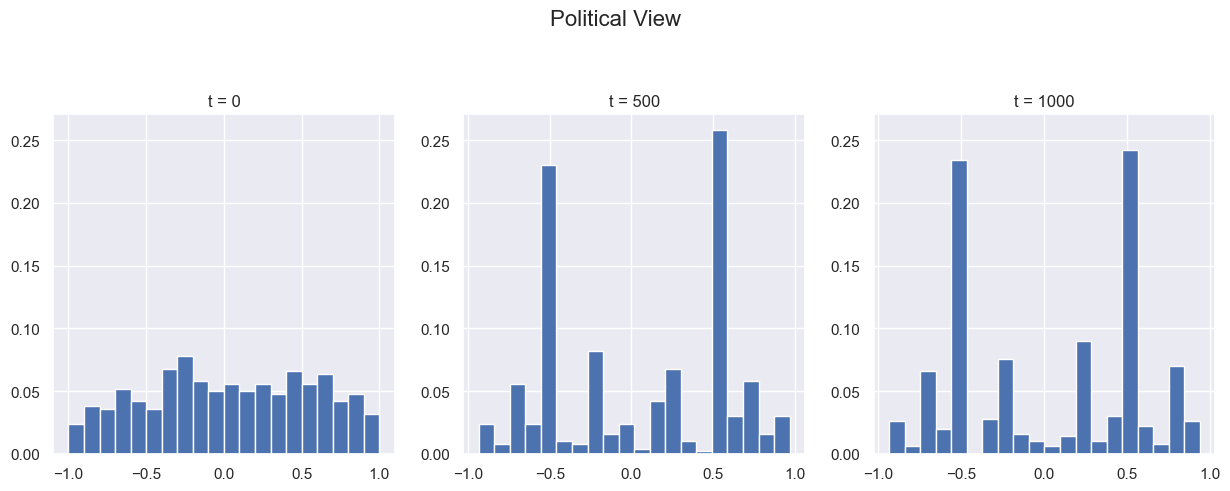

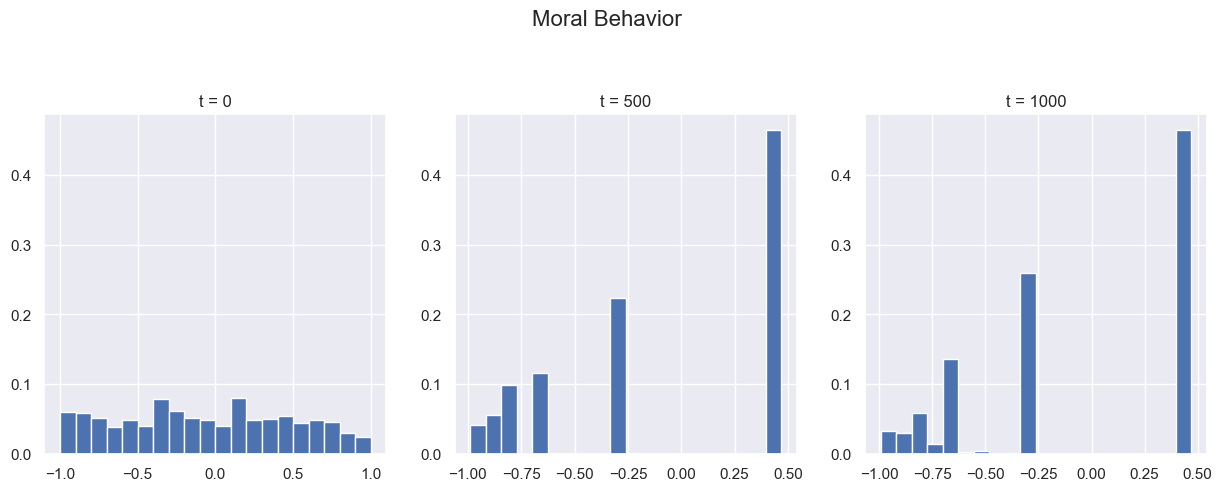

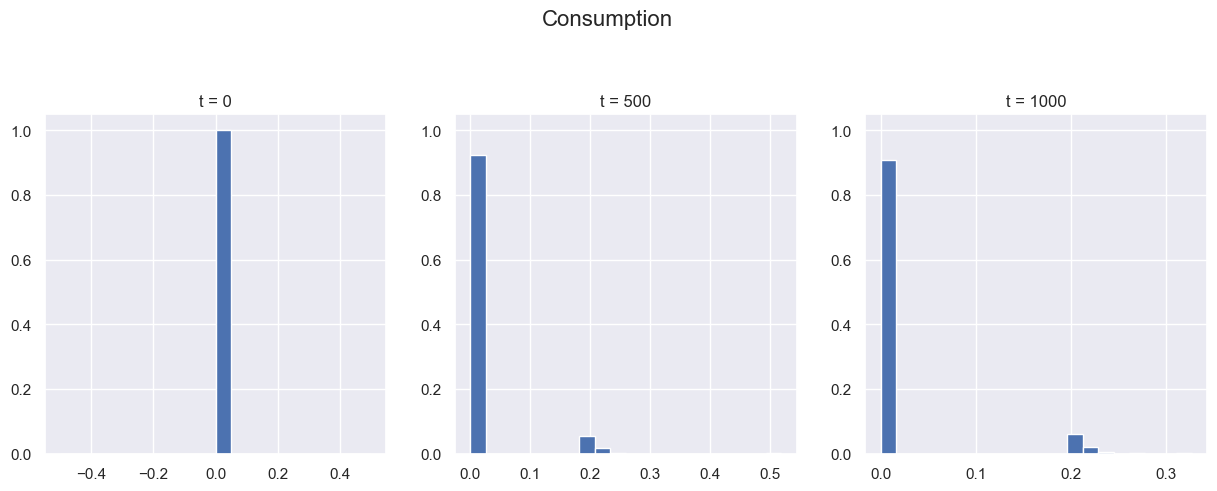

In [ ]:
cols = ['wealth', 'animal_spirits', 'political_view', 'moral_behavior', 'consumption']
for c in cols:
  make_hist(c)

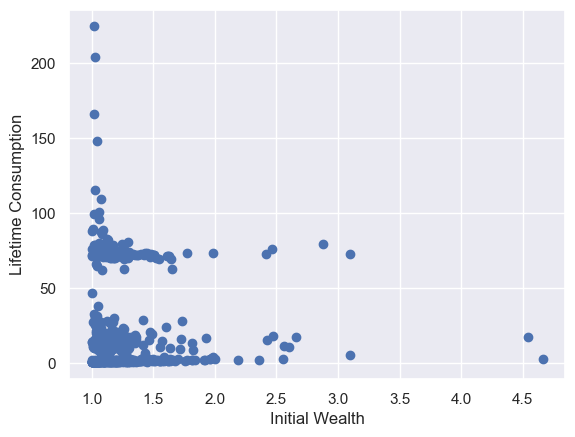

In [ ]:
agents_lifetime_consumption = df_agents['consumption'].unstack().sum()
agents_initial_wealth = df_agents['wealth'].unstack().iloc[0,:]

plt.scatter(y = agents_lifetime_consumption, x = agents_initial_wealth);
plt.xlabel('Initial Wealth');
plt.ylabel('Lifetime Consumption');
plt.savefig('{to_export}/ini_wealth_life_consumption.png');

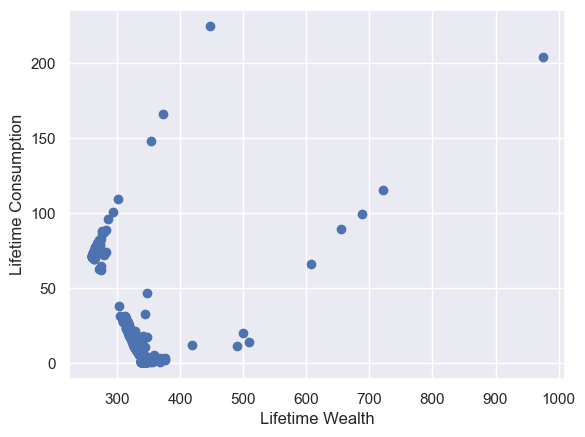

In [ ]:
agents_lifetime_consumption = df_agents['consumption'].unstack().sum()
agents_lifetime_wealth = df_agents['wealth'].unstack().sum()

plt.scatter(y = agents_lifetime_consumption, x = agents_lifetime_wealth);
plt.xlabel('Lifetime Wealth');
plt.ylabel('Lifetime Consumption');
plt.savefig('{to_export}/life_wealth_life_consumption.png');

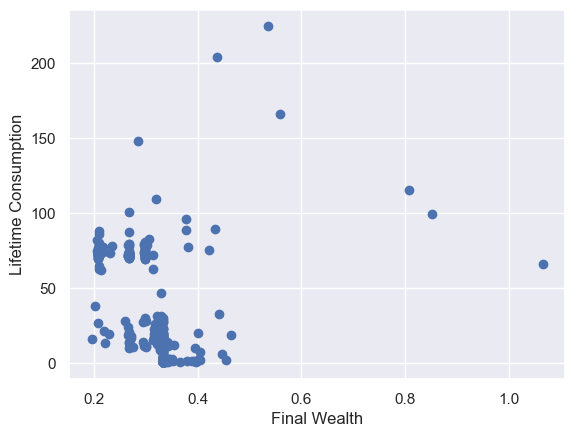

In [ ]:
agents_final_wealth = df_agents['wealth'].unstack().iloc[df_model.shape[0] - 1,:]

plt.scatter(y = agents_lifetime_consumption, x = agents_final_wealth);
plt.xlabel('Final Wealth');
plt.ylabel('Lifetime Consumption');
plt.savefig('{to_export}/fin_wealth_life_consumption.png');

Text(0.5, 1.0, 'Connectivity')

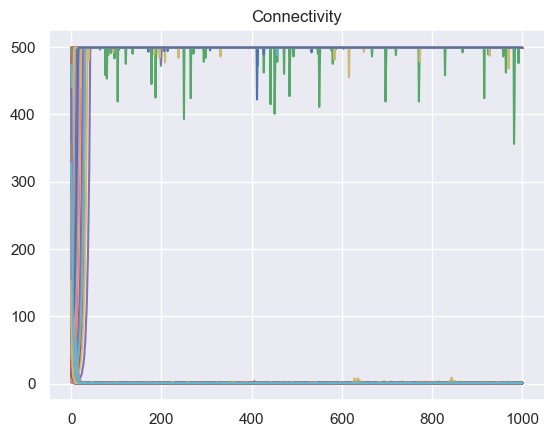

In [ ]:
plt.plot(df_agents['connectivity'].unstack());
plt.title('Connectivity');
plt.savefig('{to_export}/connectivity_in_time.png');

Text(0.5, 1.0, 'Consumption')

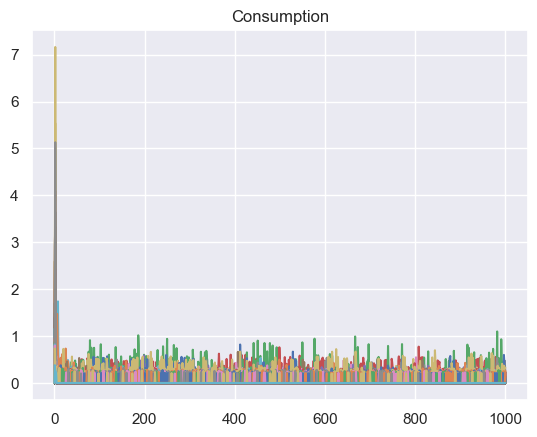

In [ ]:
plt.plot(df_agents['consumption'].unstack());
plt.title('Consumption');
plt.savefig('{to_export}/consumption_in_time.png');

Text(0.5, 1.0, 'Wealth')

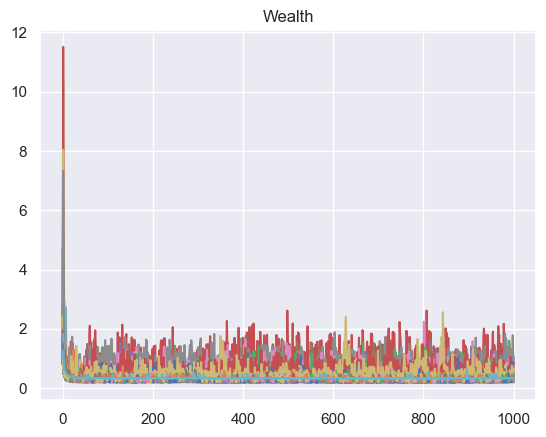

In [ ]:
plt.plot(df_agents['wealth'].unstack());
plt.title('Wealth');
plt.savefig('{to_export}/wealth_in_time.png');

Text(0.5, 1.0, 'Moral Behavior')

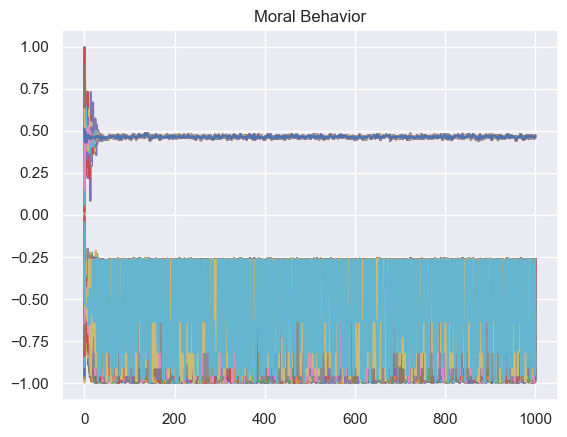

In [ ]:
plt.plot(df_agents['moral_behavior'].unstack());
plt.title('Moral Behavior');
plt.savefig('{to_export}/moral_behavior_in_time.png');

Text(0.5, 1.0, 'Political View')

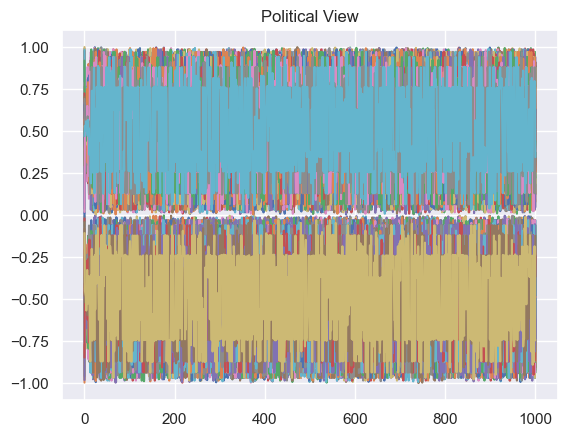

In [ ]:
plt.plot(df_agents['political_view'].unstack());
plt.title('Political View');
plt.savefig('{to_export}/political_view_in_t.png');

Text(0.5, 1.0, 'Final vs Initial wealth')

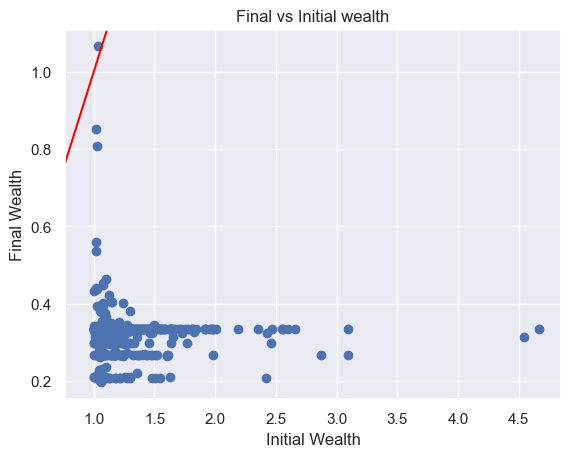

In [ ]:
plt.scatter(x=df_agents['wealth'].unstack().iloc[0,:], y=df_agents['wealth'].unstack().iloc[-1 , :]);
plt.axline((0.95, 0.95), slope = 1, color = 'red');
plt.xlabel('Initial Wealth');
plt.ylabel('Final Wealth');
plt.title('Final vs Initial wealth');
plt.savefig('{to_export}/ini_wealth_fin_wealth.png');

## Aggregate, the model

In [ ]:
df_model.head()

,n_agents,tax
0,500,0.000000
1,500,0.481025
2,500,0.480339
3,500,0.480630
4,500,0.481631


<Axes: >

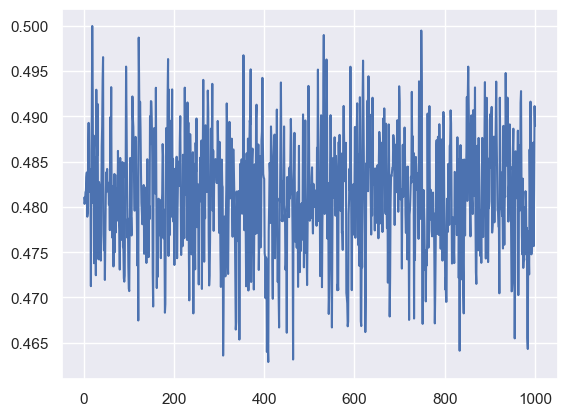

In [ ]:
df_model['tax'].iloc[1:].plot();
plt.title(f'Average Tax {df_model['tax'].iloc[1:].mean()}');
plt.xlabel('t');
plt.savefig('{to_export}/tax_in_t.png');

Text(0.5, 1.0, 'Average Political View 0.036')

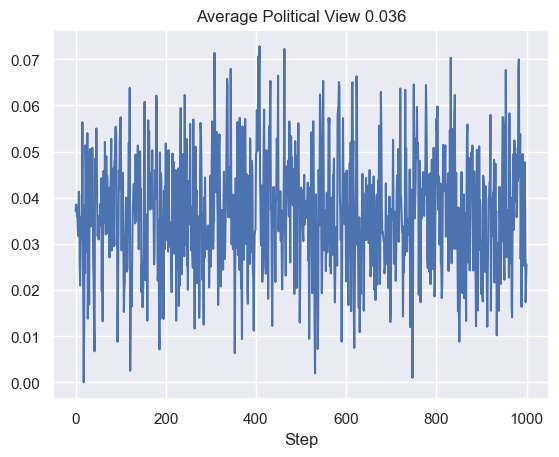

In [ ]:
df_agents['political_view'].unstack().mean(axis = 1).plot();
plt.title(f'Average Political View {np.round(df_agents['political_view'].unstack().mean(axis = 1).mean(), 3)}');
plt.xlabel('t');
plt.savefig('{to_export}/political_view_in_t.png');

Text(0, 0.5, 'connectivity')

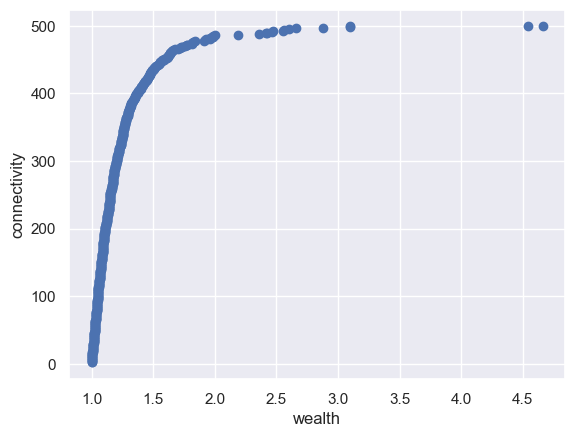

In [ ]:
plt.scatter(
        x = df_agents['wealth'].unstack().iloc[0,:], 
        y = df_agents['connectivity'].unstack().iloc[0,:]
    );
plt.xlabel('Wealth (t=0)');
plt.ylabel('Connectivity (t=0)');
plt.savefig('{to_export}/ini_wealth_ini_connectivity.png');